# Credit Card Fraud Detection
## Notebook 3: Final Model & Export untuk Deployment

---

### Tujuan Notebook

1. Melatih ulang model terbaik dengan seluruh data training
2. Melakukan threshold tuning untuk optimasi bisnis|
3. Menyimpan model dan scaler untuk deployment
4. Membuat fungsi prediksi untuk testing

### Model Terpilih

Berdasarkan hasil evaluasi di notebook sebelumnya, model yang dipilih adalah **Random Forest (Baseline)** dengan performa:
- F1-Score: 0.875
- Precision: 0.941
- Recall: 0.817

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score
)

import joblib
import os

import warnings
warnings.filterwarnings('ignore')

print("Libraries berhasil di-import")

Libraries berhasil di-import


## 2. Load dan Preprocessing Data

In [2]:
# Load data
df = pd.read_csv('../data/creditcard.csv')

# Scaling
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_scaled'] = scaler.fit_transform(df[['Time']])

# Simpan scaler untuk Amount (akan dibutuhkan saat deployment)
amount_scaler = StandardScaler()
amount_scaler.fit(df[['Amount']])

time_scaler = StandardScaler()
time_scaler.fit(df[['Time']])

# Drop kolom original
df_processed = df.drop(['Amount', 'Time'], axis=1)

# Split features dan target
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Testing set: {X_test.shape[0]:,} samples")

Training set: 227,845 samples
Testing set: 56,962 samples


## 3. Training Final Model

Melatih Random Forest dengan parameter yang sudah optimal.

In [3]:
# Training Random Forest
final_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)
print("Model selesai dilatih")

# Evaluasi
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print(f"\nPerforma pada Test Set:")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

Model selesai dilatih

Performa pada Test Set:
Precision: 0.9412
Recall: 0.8163
F1-Score: 0.8743


## 4. Threshold Tuning

Default threshold adalah 0.5. Namun untuk fraud detection, threshold bisa disesuaikan berdasarkan kebutuhan bisnis:
- **Threshold rendah**: Tangkap lebih banyak fraud (recall tinggi), tapi lebih banyak false alarm
- **Threshold tinggi**: Sedikit false alarm (precision tinggi), tapi bisa melewatkan fraud

### Analisis Trade-off

# Analisis berbagai threshold
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    results.append({
        'threshold': thresh,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })

threshold_df = pd.DataFrame(results)

# Visualisasi
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', linewidth=2)
ax.plot(threshold_df['threshold'], threshold_df['f1'], label='F1-Score', linewidth=2, linestyle='--')

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-Score vs Threshold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')

plt.tight_layout()
plt.savefig('../figures/threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Cari threshold dengan F1 tertinggi
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']

print("Threshold Optimal berdasarkan F1-Score:")
print(f"  Threshold: {optimal_threshold:.2f}")
print(f"  Precision: {threshold_df.loc[optimal_idx, 'precision']:.4f}")
print(f"  Recall: {threshold_df.loc[optimal_idx, 'recall']:.4f}")
print(f"  F1-Score: {threshold_df.loc[optimal_idx, 'f1']:.4f}")

Threshold Optimal berdasarkan F1-Score:
  Threshold: 0.45
  Precision: 0.9318
  Recall: 0.8367
  F1-Score: 0.8817


## 5. Feature Importance

Melihat fitur mana yang paling berpengaruh dalam mendeteksi fraud.

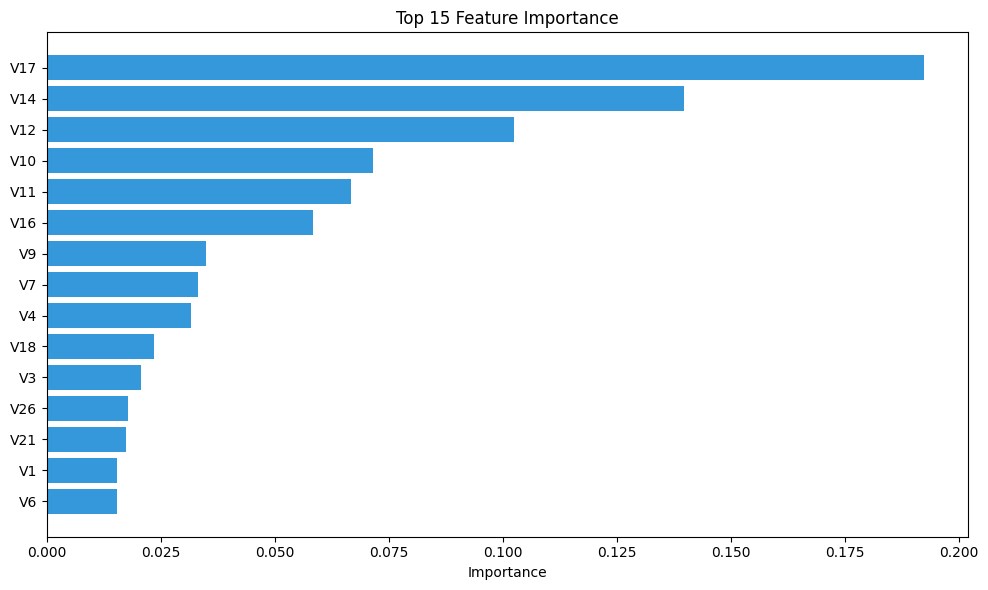

Top 10 Fitur Paling Penting:
feature  importance
    V17    0.192278
    V14    0.139783
    V12    0.102377
    V10    0.071407
    V11    0.066568
    V16    0.058255
     V9    0.034783
     V7    0.033137
     V4    0.031502
    V18    0.023424


In [7]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualisasi top 15 fitur
fig, ax = plt.subplots(figsize=(10, 6))

top_features = feature_importance.head(15)
ax.barh(top_features['feature'], top_features['importance'], color='#3498db')
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importance')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top 10 Fitur Paling Penting:")
print(feature_importance.head(10).to_string(index=False))

## 6. Menyimpan Model

Menyimpan model dan scaler ke folder `models/` untuk digunakan saat deployment.

In [8]:
# Buat folder models jika belum ada
models_dir = '../models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Simpan model
joblib.dump(final_model, f'{models_dir}/fraud_detection_model.joblib')
print(f"Model disimpan: {models_dir}/fraud_detection_model.joblib")

# Simpan scaler
joblib.dump(amount_scaler, f'{models_dir}/amount_scaler.joblib')
joblib.dump(time_scaler, f'{models_dir}/time_scaler.joblib')
print(f"Scaler disimpan: {models_dir}/amount_scaler.joblib")
print(f"Scaler disimpan: {models_dir}/time_scaler.joblib")

# Simpan threshold optimal
config = {
    'optimal_threshold': optimal_threshold,
    'feature_columns': list(X_train.columns)
}
joblib.dump(config, f'{models_dir}/model_config.joblib')
print(f"Config disimpan: {models_dir}/model_config.joblib")

Model disimpan: ../models/fraud_detection_model.joblib
Scaler disimpan: ../models/amount_scaler.joblib
Scaler disimpan: ../models/time_scaler.joblib
Config disimpan: ../models/model_config.joblib


## 7. Testing Fungsi Prediksi

Membuat fungsi prediksi dan menguji dengan sample data.

In [9]:
def predict_fraud(transaction_data, model, amount_scaler, time_scaler, config, threshold=None):
    """
    Fungsi untuk memprediksi apakah transaksi fraud atau tidak.
    
    Parameters:
    - transaction_data: dict dengan keys sesuai fitur
    - model: trained model
    - amount_scaler: fitted scaler untuk Amount
    - time_scaler: fitted scaler untuk Time
    - config: model configuration
    - threshold: custom threshold (default: optimal threshold)
    
    Returns:
    - dict dengan hasil prediksi
    """
    if threshold is None:
        threshold = config['optimal_threshold']
    
    # Buat dataframe dari input
    df_input = pd.DataFrame([transaction_data])
    
    # Scaling Amount dan Time
    df_input['Amount_scaled'] = amount_scaler.transform(df_input[['Amount']])
    df_input['Time_scaled'] = time_scaler.transform(df_input[['Time']])
    
    # Drop kolom original
    df_input = df_input.drop(['Amount', 'Time'], axis=1)
    
    # Pastikan urutan kolom sama dengan training
    df_input = df_input[config['feature_columns']]
    
    # Prediksi
    prob = model.predict_proba(df_input)[0, 1]
    prediction = 1 if prob >= threshold else 0
    
    return {
        'prediction': 'FRAUD' if prediction == 1 else 'NORMAL',
        'fraud_probability': round(prob, 4),
        'threshold_used': threshold
    }

In [10]:
# Load model dan scaler
loaded_model = joblib.load(f'{models_dir}/fraud_detection_model.joblib')
loaded_amount_scaler = joblib.load(f'{models_dir}/amount_scaler.joblib')
loaded_time_scaler = joblib.load(f'{models_dir}/time_scaler.joblib')
loaded_config = joblib.load(f'{models_dir}/model_config.joblib')

# Ambil sample dari test set
sample_normal = X_test[y_test == 0].iloc[0].to_dict()
sample_fraud = X_test[y_test == 1].iloc[0].to_dict()

# Tambahkan Amount dan Time (ambil dari data original)
sample_normal['Amount'] = df.loc[X_test[y_test == 0].index[0], 'Amount']
sample_normal['Time'] = df.loc[X_test[y_test == 0].index[0], 'Time']

sample_fraud['Amount'] = df.loc[X_test[y_test == 1].index[0], 'Amount']
sample_fraud['Time'] = df.loc[X_test[y_test == 1].index[0], 'Time']

print("Test Prediksi Sample Normal:")
result_normal = predict_fraud(sample_normal, loaded_model, loaded_amount_scaler, loaded_time_scaler, loaded_config)
print(f"  Hasil: {result_normal['prediction']}")
print(f"  Probabilitas Fraud: {result_normal['fraud_probability']}")

print("\nTest Prediksi Sample Fraud:")
result_fraud = predict_fraud(sample_fraud, loaded_model, loaded_amount_scaler, loaded_time_scaler, loaded_config)
print(f"  Hasil: {result_fraud['prediction']}")
print(f"  Probabilitas Fraud: {result_fraud['fraud_probability']}")

Test Prediksi Sample Normal:
  Hasil: NORMAL
  Probabilitas Fraud: 0.0

Test Prediksi Sample Fraud:
  Hasil: FRAUD
  Probabilitas Fraud: 0.96


## 8. Summary

### Model Final
- **Algorithm**: Random Forest Classifier
- **Estimators**: 100 trees
- **Optimal Threshold**: (lihat output di atas)

### File yang Dihasilkan
```
models/
├── fraud_detection_model.joblib    # Model utama
├── amount_scaler.joblib            # Scaler untuk fitur Amount
├── time_scaler.joblib              # Scaler untuk fitur Time
└── model_config.joblib             # Konfigurasi (threshold, feature columns)
```

### Langkah Selanjutnya
1. Membuat API endpoint dengan FastAPI/Flask
2. Membuat UI sederhana untuk demo
3. Deploy ke cloud (Heroku/Railway/etc)

---

In [12]:
print("=" * 60)
print("FRAUD DETECTION MODEL - READY FOR DEPLOYMENT")
print("=" * 60)
print(f"\nModel: Random Forest Classifier")
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"\nPerforma:")
print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"\nFiles saved in: {models_dir}/")
print("=" * 60)

FRAUD DETECTION MODEL - READY FOR DEPLOYMENT

Model: Random Forest Classifier
Optimal Threshold: 0.45

Performa:
  Precision: 0.9412
  Recall: 0.8163
  F1-Score: 0.8743

Files saved in: ../models/
